# Statistical Analysis

Use various methods to answer the following questions:
* What factors are significantly related to the number of store purchases?
* Does US fare significantly better than the Rest of the World in terms of total purchases?
* Your supervisor insists that people who buy gold are more conservative. Therefore, people who spent an above average amount on gold in the last 2 years would have more in store purchases. Justify or refute this statement using an appropriate statistical test
* Fish has Omega 3 fatty acids which are good for the brain. Accordingly, do "Married PhD candidates" have a significant relation with amount spent on fish? What other factors are significantly related to amount spent on fish? (Hint: use your knowledge of interaction variables/effects)
* Is there a significant relationship between geographical regional and success of a campaign?

## Imports and Constants

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import LabelEncoder
import statsmodels.api as sm
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer
from sklearn.inspection import permutation_importance
import seaborn as sns

/Users/freethrall/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
DATA_PATH = '../data/'
DATA_FILE = 'marketing_data_clean.csv'

## Helper Functions

In [3]:
def df_ohe(data, col, prefix=''):
    """
    Create One Hot Encoded (OHE) features for a column and 
    return the updated dataframe
    
    Parameters:
    data: dataframe
    col: column in dataframe for OHE process
    prefix: prefix to add the the new columns
    """
    dummies = pd.get_dummies(data[col],
                            prefix=prefix,
                            drop_first=True)
    data = data.drop(col, axis=1)
    data = pd.concat([data, dummies], axis=1)
    return data

In [4]:
def make_category(data, col):
    """
    Make a dataframe column a category and perform a One Hot Encoding on it,
    and return the updated dataframe
    
    Parameters:
    data: dataframe
    col: column in dataframe for OHE process
    prefix: prefix to add the the new columns
    
    """
    suffix='_encoded'
    lb_make = LabelEncoder()
    data[col] = data[col].astype('category')
    data[col+suffix] = lb_make.fit_transform(data[col])
    data = data.drop(col, axis=1)
    data = df_ohe(data, col+suffix, col+'_')
    return data

## Read Data File

In [5]:
df = pd.read_csv(DATA_PATH + DATA_FILE, parse_dates=['Dt_Customer'])

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2240 entries, 0 to 2239
Data columns (total 35 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   ID                       2240 non-null   int64         
 1   Year_Birth               2240 non-null   int64         
 2   Education                2240 non-null   object        
 3   Marital_Status           2240 non-null   object        
 4   Income                   2216 non-null   object        
 5   Kidhome                  2240 non-null   int64         
 6   Teenhome                 2240 non-null   int64         
 7   Dt_Customer              2240 non-null   datetime64[ns]
 8   Recency                  2240 non-null   int64         
 9   MntWines                 2240 non-null   int64         
 10  MntFruits                2240 non-null   int64         
 11  MntMeatProducts          2240 non-null   int64         
 12  MntFishProducts          2240 non-

## What factors are significantly related to the number of store purchases?

### Prepare Data

In [7]:
fields_to_ignore = ['ID', 'Marital_Status', 'Income', 'Kidhome', 'Teenhome', 
                    'Marital_Status_Group', 'marital_status_children', 
                    'income_q4', 'income_q10', 'Dt_Customer']

In [8]:
X = df.drop(fields_to_ignore, axis=1)

In [9]:
y = df.NumStorePurchases

In [10]:
X = X.drop(['NumStorePurchases'], axis=1)

In [11]:
cat_fields = ['Education', 'Country', 'Marital_Status_Clean', 'any_children']

In [12]:
for cat in cat_fields:
    X = make_category(X, cat)

### Check for Multicolinearity

Text(0.5, 1, 'Correlation Heatmap')

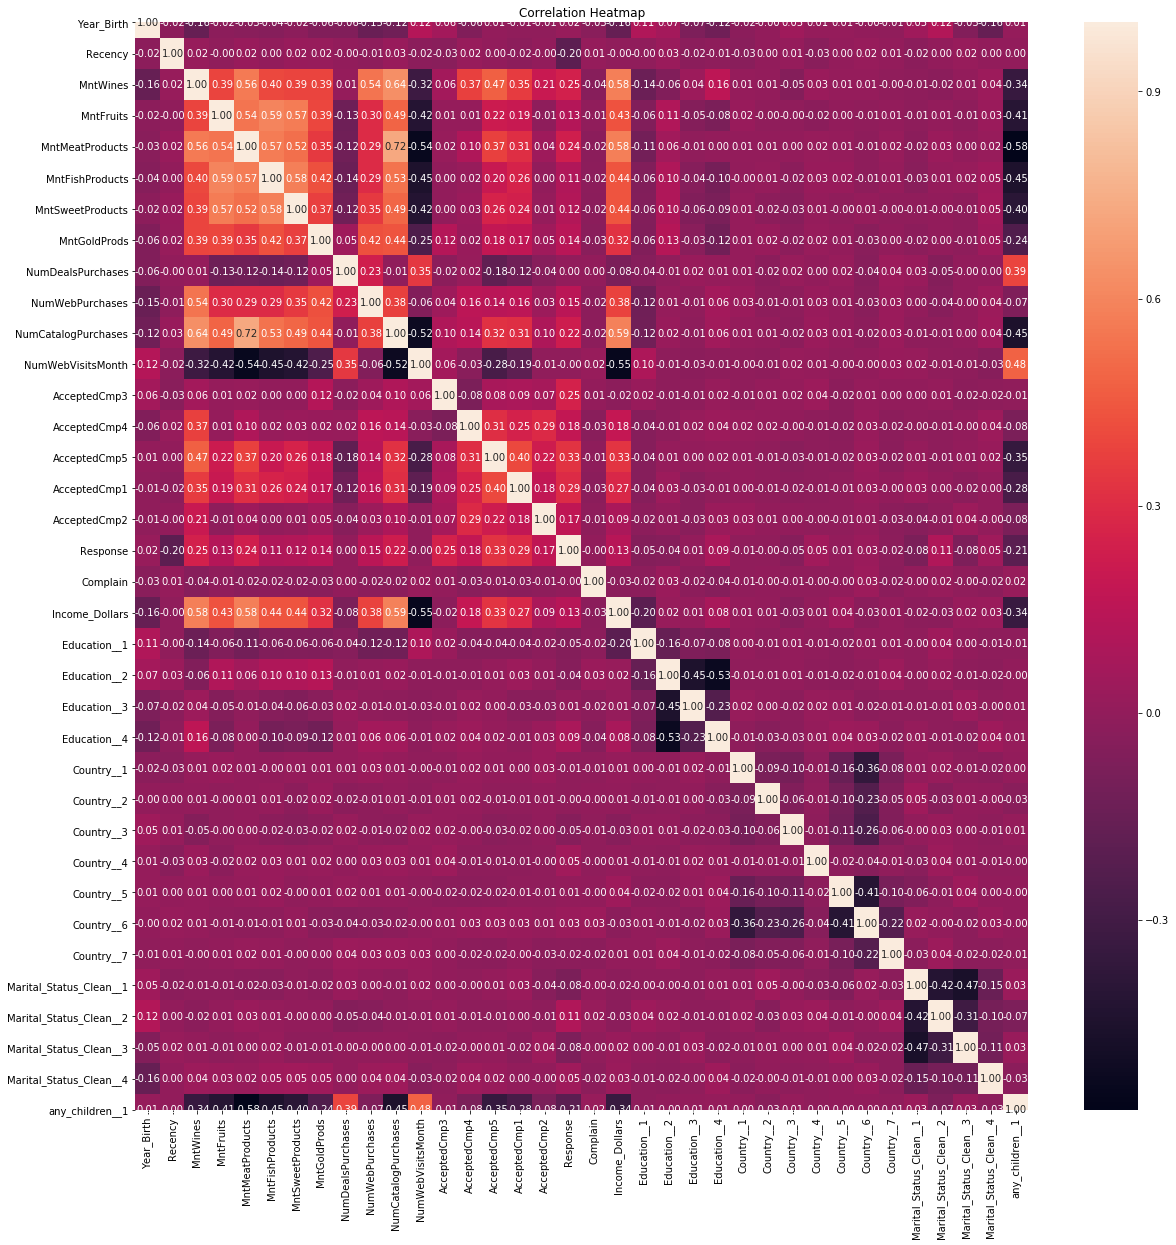

In [13]:
plt.figure(figsize=(20, 20))
ax = sns.heatmap(X.corr(), annot=True, fmt='.2f')
ax.set_title('Correlation Heatmap')

Drop NumCatalogPurchases because of multicoliniarity with MntMeatProducts and MntWines 

In [14]:
# drop because of multicoliniarity with NumCatalogPurchases
df.drop(['NumCatalogPurchases'], axis=1, inplace=True)

### Linear Regression

Because I am just just want to know feature importance, I will not be doing a train/test split.

In [15]:
lin_reg = LinearRegression()
lin_reg.fit(X, y)

y_hat = lin_reg.predict(X)

mse = mean_squared_error(y, y_hat)

mae = mean_absolute_error(y, y_hat)

print(f'RMSE: {np.sqrt(mse)}')
print(f'')
print(f'MAE: {mae}')
print('')

mse_scorer = make_scorer(mean_squared_error)

cv_rmse = np.sqrt(np.mean(cross_val_score(lin_reg, X, 
                                                y, cv=10,
                                               scoring=mse_scorer)))
print(f'Cross Val RMSE: {cv_rmse}')

RMSE: 2.106216124951377

MAE: 1.4875822056247958

Cross Val RMSE: 2.181088572669135


### Feature Importance

In [16]:
results = permutation_importance(lin_reg, X, y)

In [17]:
importance = list(zip(X.columns, results.importances_mean))

In [18]:
importance.sort(key = lambda x: x[1], reverse=True)

In [19]:
print('The most important factors determining NumStorePurchases')
print('')
for feature, score in importance[:5]:
    print(f'Feature: {feature}, Score: {round(score, 4)}')

The most important factors determining NumStorePurchases

Feature: MntWines, Score: 0.3934
Feature: NumWebVisitsMonth, Score: 0.1156
Feature: NumWebPurchases, Score: 0.0556
Feature: NumDealsPurchases, Score: 0.0301
Feature: MntFruits, Score: 0.0253
